# Customer Review Analysis with Classification Algorithms

### In this project find various trends and patterns in the reviews data and create useful insights for product quality

# Import Libraries

In [170]:
import numpy as np
import pandas as pd
import nltk
import string
import seaborn as sns
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from tqdm import tqdm
import re
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [171]:
# read the dataset
data = pd.read_csv('Reviews.csv', on_bad_lines='skip')
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [172]:
data.shape

(568454, 10)

In [173]:
# not consider "Score= 3" reviews, so drop it
data = data[data['Score'] != 3]
data.shape

(525814, 10)

In [174]:
# given x return 1 if x > 3 else return 0
def partition(x):
    if x < 3:
        return 0
    return 1   

# change the review score less than 3 be negative and greater than 3 be positive
actual_score = data['Score']
positive_negative = actual_score.map(partition)
data['Score'] = positive_negative
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,0,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,1,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [175]:
data['Score'].value_counts()

Score
1    443777
0     82037
Name: count, dtype: int64

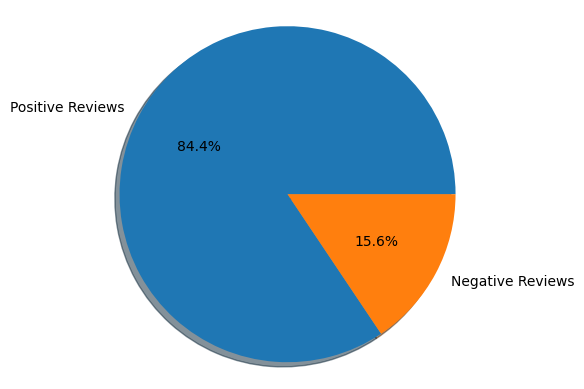

In [176]:
# plot the pie chat
labels = 'Positive Reviews', 'Negative Reviews'
sizes = [443777, 82037]
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True)
ax.axis('equal')
plt.show()

In [177]:
# sort product id column then drop duplicates 
sorted_data = data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

final = sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first', inplace= False)

In [178]:
final.shape

(364173, 10)

In [179]:
# this function convert contractions to full words
def decontracted(phrase):
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# remove the words from the stop words list (https://gist.github.com/sebleier/554280)
stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# Preprocessing

In [180]:
#  Text column remove url, html tags, words with numbers, special character, stop words, decontracts words in the Text each review
preprocessed_reviews = []
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364173/364173 [01:07<00:00, 5434.21it/s]


In [181]:
#  Text column remove url, html tags, words with numbers, special character, stop words, decontracts words in the Text each reviewabs
preprocessed_summary = []
for sentance in tqdm(final['Summary'].values):
    sentance = re.sub(r"http\S+", "", str(sentance))
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentance.strip())

100%|████████████████████████████████████████████████████████████████████████| 364173/364173 [00:38<00:00, 9572.03it/s]


In [182]:
# let's replace the 'Summary' and 'Text' column with the preprocessed data
final['Summary'] = preprocessed_summary
final['Text'] = preprocessed_reviews
final.drop(['Id','ProductId','UserId','ProfileName'], axis=1, inplace=True)
final.reset_index(inplace= True)

In [183]:
final.drop(['index'], axis=1, inplace= True)
final.head()

,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,0,0,1,939340800,every book educational,witty little book makes son laugh loud recite ...
1,1,1,1,1194739200,love book miss hard cover version,grew reading sendak books watching really rosi...
2,1,1,1,1191456000,chicken soup rice months,fun way children learn months year learn poems...
3,1,1,1,1076025600,good swingy rhythm reading aloud,great little book read aloud nice rhythm well ...
4,3,4,1,1018396800,great way learn months,book poetry months year goes month cute little...


In [184]:
X = final.drop(['Score'], axis=1)
y = final['Score'].values

In [185]:
# split the data and class labels into train set and test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

In [186]:
print('train data shape', X_train.shape)
print('train data labels shape', y_train.shape)
print('test data shape', X_test.shape)
print('test data labels shape', y_test.shape)

train data shape (254921, 5)
train data labels shape (254921,)
test data shape (109252, 5)
test data labels shape (109252,)


In [187]:
# libraries for featurization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import Normalizer

In [188]:
# "Text" feature
vectorizer_text = CountVectorizer(min_df=10, ngram_range=(1,4), max_features= 5000)
vectorizer_text.fit(X_train['Text'].values)

X_train_text = vectorizer_text.transform(X_train['Text'].values)
X_test_text  = vectorizer_text.transform(X_test['Text'].values)

features_text = vectorizer_text.get_feature_names_out()

print('After vectorizations using BOW')
print(X_train_text.shape, y_train.shape)
print(X_test_text.shape, y_test.shape)

After vectorizations using BOW
(254921, 5000) (254921,)
(109252, 5000) (109252,)


In [189]:
# "Summary" feature
vectorizer_summary = CountVectorizer(min_df=10, ngram_range=(1,4), max_features= 5000)
vectorizer_summary.fit(X_train['Summary'].values)

X_train_summary = vectorizer_summary.transform(X_train['Summary'].values)
X_test_summary  = vectorizer_summary.transform(X_test['Summary'].values)

features_summary = vectorizer_summary.get_feature_names_out()
print('After vectorizations using BOW')
print(X_train_summary.shape, y_train.shape)
print(X_test_summary.shape, y_test.shape)

After vectorizations using BOW
(254921, 5000) (254921,)
(109252, 5000) (109252,)


In [190]:
# "HelpfulnessNumerator"	feature
normalizer = Normalizer()
normalizer.fit(X_train['HelpfulnessNumerator'].values.reshape(-1,1))

X_train_help_num = normalizer.transform(X_train['HelpfulnessNumerator'].values.reshape(-1,1))
X_test_help_num = normalizer.transform(X_test['HelpfulnessNumerator'].values.reshape(-1,1))

print("After normalization of price feature")
print(X_train_help_num.shape, y_train.shape)
print(X_test_help_num.shape, y_test.shape)

After normalization of price feature
(254921, 1) (254921,)
(109252, 1) (109252,)


In [191]:
# "HelpfulnessDenominator" feature
normalizer = Normalizer()
normalizer.fit(X_train['HelpfulnessDenominator'].values.reshape(-1,1))

X_train_help_den = normalizer.transform(X_train['HelpfulnessDenominator'].values.reshape(-1,1))
X_test_help_den  = normalizer.transform(X_test['HelpfulnessDenominator'].values.reshape(-1,1))


print("After normalization of price feature")
print(X_train_help_den.shape, y_train.shape)
print(X_test_help_den.shape, y_test.shape)

After normalization of price feature
(254921, 1) (254921,)
(109252, 1) (109252,)


In [192]:
# "Time" feature
normalizer = Normalizer()
normalizer.fit(X_train['Time'].values.reshape(-1,1))

X_train_time = normalizer.transform(X_train['Time'].values.reshape(-1,1))
X_test_time = normalizer.transform(X_test['Time'].values.reshape(-1,1))


print("After normalization of price feature")
print(X_train_time.shape, y_train.shape)
print(X_test_time.shape, y_test.shape)

After normalization of price feature
(254921, 1) (254921,)
(109252, 1) (109252,)


In [193]:
from scipy.sparse import hstack

X_tr = hstack((X_train_text, X_train_summary, X_train_help_num,  # train data after BOW representation for 'Text' and 'Summary' feature.
                   X_train_help_den, X_train_time)).tocsr()

X_te = hstack((X_test_text, X_test_summary, X_test_help_num,  # test data after BOW representation for 'Text' and 'Summary' feature.
                   X_test_help_den, X_test_time)).tocsr()


print("Final Data matrix with BOW representation for essay")
print(X_tr.shape, y_train.shape)
print(X_te.shape, y_test.shape)

Final Data matrix with BOW representation for essay
(254921, 10003) (254921,)
(109252, 10003) (109252,)


In [194]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB(class_prior=[0.5, 0.5])
parameters = {'alpha': [0.001, 0.05, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 2, 3, 4, 5, 10, 20, 25, 30, 50, 70, 100]}  # various values of alhap's to choose from.
clf = GridSearchCV(NB_classifier, parameters, cv=5, scoring='roc_auc', return_train_score=True)  # gridsearchCV with 5 fold cross validation .
clf.fit(X_tr, y_train)

results = pd.DataFrame.from_dict(clf.cv_results_)
results = results.sort_values(['param_alpha'])

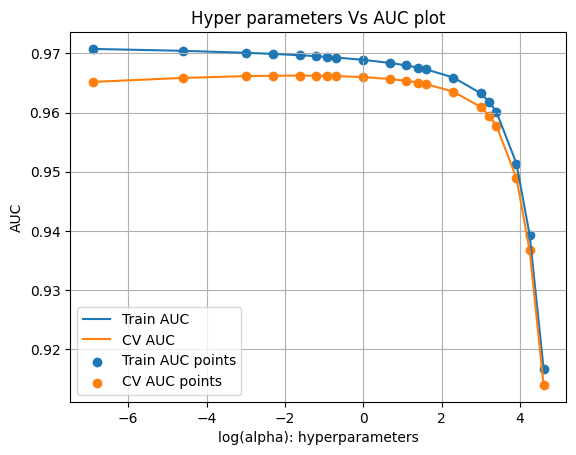

In [195]:
cv_auc = results['mean_test_score']      # mean test scores for every 'alpha'
train_auc = results['mean_train_score']  # mean train scores for every 'alpha

alpha =  list(results['param_alpha'])
alpha=np.log(alpha)   # taking log of alphas so to make the plot more readable

plt.plot(alpha, train_auc, label='Train AUC')
plt.plot(alpha, cv_auc, label='CV AUC')

plt.scatter(alpha, train_auc, label='Train AUC points')
plt.scatter(alpha, cv_auc, label='CV AUC points')


plt.legend()
plt.xlabel("log(alpha): hyperparameters")
plt.ylabel("AUC")
plt.title("Hyper parameters Vs AUC plot")
plt.grid()
plt.show()

In [196]:
clf.best_estimator_ # using this estimator lets predict the labels of test dataset

MultinomialNB(alpha=0.2, class_prior=[0.5, 0.5])

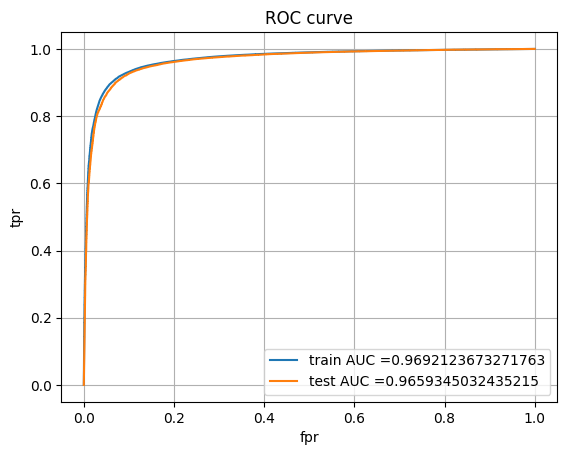

In [197]:
from sklearn.metrics import roc_curve, auc
NBclassifier = MultinomialNB(alpha=0.2, class_prior=[0.5, 0.5], fit_prior=True)
NBclassifier.fit(X_tr, y_train)

y_train_pred = NBclassifier.predict_proba(X_tr)[:,1]     # predicted probabilities of train datapoints belonging to positive class
y_test_pred = NBclassifier.predict_proba(X_te)[:,1]      # predicted probabilities of test datapoints belonging to positive class

train_fpr, train_tpr, tr_thresholds = roc_curve(y_train, y_train_pred)   # fpr and tpr for train data
test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)       # fpr and tpr for test data

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC curve")
plt.grid()
plt.show()

In [198]:
def find_best_threshold(threshould, fpr, tpr):
    t = threshould[np.argmax(tpr*(1-fpr))]
    # (tpr*(1-fpr)) will be maximum if  fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(proba, threshould):
    predictions = []
    for i in proba:
        if i>=threshould:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [199]:
from sklearn.metrics import confusion_matrix

best_t = find_best_threshold(tr_thresholds, train_fpr, train_tpr)  # getting the best threshold for separating the positive classes form negative

test_confusion_matrix = confusion_matrix(y_test, predict_with_best_t(y_test_pred, best_t))  # calculates the confusion matrix


the maximum value of tpr*(1-fpr) 0.8462189553795799 for threshold 0.497


Test confusion matrix


<Axes: >

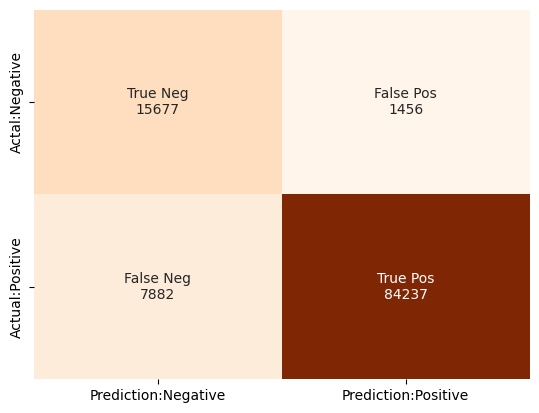

In [200]:
group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ['{0:0.0f}'.format(value) for value in
                test_confusion_matrix.flatten()]

labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names,group_counts)]
labels = np.asarray(labels).reshape(2,2)

print("Test confusion matrix")
sns.heatmap(test_confusion_matrix, annot=labels, fmt='', cmap='Oranges',cbar=False, xticklabels=['Prediction:Negative', 'Prediction:Positive'], yticklabels=['Actal:Negative', 'Actual:Positive'])

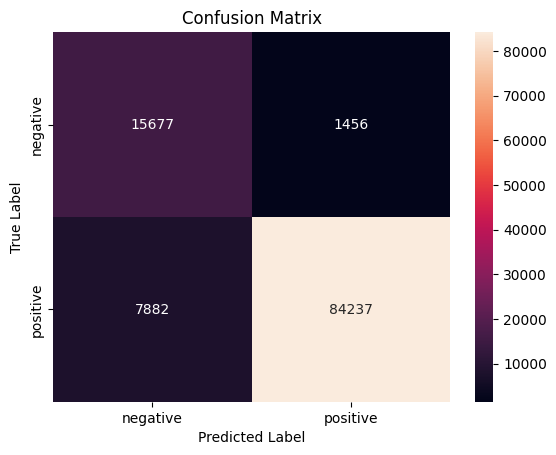

In [201]:
class_label = ["negative", "positive"]
df_cm = pd.DataFrame(test_confusion_matrix, index = class_label, columns = class_label)
sns.heatmap(df_cm, annot = True, fmt = "d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [209]:
list_of_features = feature_text + feature_summary 

# Top 20 features form negative class
features = np.argsort(NBclassifier.feature_log_prob_[0]) # sorting the features log probability for negative class
                                                         # from low probability to high probability and getting its indices

# Filter out indices that are out of bounds
features = features[features < len(list_of_features)]  # Only keep indices that are within bounds

features = features[::-1]  # reversing it from high probability to low probability indices
neg_features = features

# Make sure we don't try to print more than we have
num_to_print = min(20, len(neg_features))
for i in features[:num_to_print]:  # printing top features from negative class
    print(list_of_features[i])

nonemac
lifthigh price
problemparents
would buyworst ever
tapsunshine
old fashionednature valley
go wronggi
next daylove taste
coffee coffeecheck
fishfast service
gavefree shipping
espressodry dog
fluffyfilters
tasting coffeesweetner
buy bulkbodied
amazinglyapparently
readingpoop
mountainlisted
coughcoffee pods
box notbest value


In [211]:
list_of_features = feature_text + feature_summary 

# Top 20 features form positive class
features = np.argsort(NBclassifier.feature_log_prob_[1]) # sorting the features log probability for positive class
                                                         # from low probability to high probability and getting its indices

# Filter out indices that are out of bounds
features = features[features < len(list_of_features)]  # Only keep indices that are within bounds

features = features[::-1]  # reversing it from high probability to low probability indices
pos_features = features

# Make sure we don't try to print more than we have
num_to_print = min(20, len(pos_features))
for i in features[:num_to_print]:  # printing top features from positive  class
    print(list_of_features[i])

nonemac
lifthigh price
go wronggi
grandmagood chili
old fashionednature valley
tapsunshine
problemparents
tasting coffeesweetner
lot lessinstant coffee
fishfast service
coffee coffeecheck
would buyworst ever
gavefree shipping
next daylove taste
readingpoop
fluffyfilters
usaultra
amazinglyapparently
best chocolatebest dark
alreadyambrosia
